<a href="https://colab.research.google.com/github/dsaldana/reinforcement-learning-course/blob/main/lab3_TD_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Temporal Difference Learning

In this lab, we will practice TD Learning methods, including SARSA and Q-Learning. Both are tabular methods that work on finite MDP.

We will solve the cliff problem: https://gymnasium.farama.org/environments/toy_text/cliff_walking/#is_slippy


The following code runs in colab, if you want to see the animation, you have to run it using python locally on your computer and replacing render_mode="ansi" for render_mode="human".

Thef follwing code runs the cliff problem using a random policy.

In [ ]:
import gymnasium as gym

# Create the environment
env = gym.make("CliffWalking-v1", render_mode="ansi")

n_episodes = 5      # number of episodes to run
max_steps = 100     # safety cap

for episode in range(n_episodes):
    state, info = env.reset()
    done = False
    total_reward = 0

    for step in range(max_steps):
        # Random policy: sample an action uniformly
        action = env.action_space.sample()

        next_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    print(f"Episode {episode+1}: total reward = {total_reward}")



Episode 1: total reward = -793
Episode 2: total reward = -694
Episode 3: total reward = -2080
Episode 4: total reward = -892
Episode 5: total reward = -397


## Exercise 1: SARSA
Implement SARSA to solve the cliff problem above. Recommendations:



1. Define your Q table, as a matrix of [number of states] x [number of actions]
2. Greedy policy: Write a function that receives a state, the Q table, and returns the best action (the one with the maximum Q value).
3. $\epsilon$-greedy: Wreite a function that chooses the greedy policy with $\epsilon$ probality, and chooses a random actions with 1-$\epsilon$ probability.
4. Implement the SARSA algorithm based on the pseudo-code



In [ ]:

import gymnasium as gym
import numpy as np
from tqdm import tqdm

def sarsa(print_rewards=False, is_slippery=False):
  # Create the environment
  if is_slippery:
    env = gym.make("CliffWalking-v1", render_mode="ansi", is_slippery=True)
  else:
    env = gym.make("CliffWalking-v1", render_mode="ansi", is_slippery=False)


  n_episodes = 10000      # number of episodes to run
  max_steps = 100     # safety cap

  # Q-learning parameters
  learning_rate = 0.1
  epsilon = 0.01
  discount_factor = 0.99
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states, n_actions))

  rewards = []
  def get_e_greedy_action(e):
      epsilon_loc = e
      def get_action(q_loc, env_loc, state_loc):
          if np.random.random() < epsilon_loc:
              return env_loc.action_space.sample()
          else:
              return np.argmax(q_loc[state])
      return get_action


  actin_selector = get_e_greedy_action(e=epsilon)

  for episode in range(n_episodes):
      done = False
      total_reward = 0
      state, info = env.reset()
      action = actin_selector(Q, env, state)

      for step in range(max_steps):
        next_state, reward, terminated, truncated, info = env.step(action)
        next_action = actin_selector(Q, env, state)
        Q[state, action] = Q[state, action] + learning_rate * (reward + discount_factor * Q[next_state, next_action] - Q[state, action])
        state, action = next_state, next_action
        total_reward += reward


        if terminated or truncated:
            break

      if print_rewards:
        print(f"Episode {episode+1}: total reward = {total_reward}")
      rewards.append(total_reward)
  return Q, rewards, n_actions
sarsa_Q, sarsa_rewards, n_actions = sarsa(True, False)

Streaming output truncated to the last 5000 lines.
Episode 5001: total reward = -20
Episode 5002: total reward = -20
Episode 5003: total reward = -20
Episode 5004: total reward = -20
Episode 5005: total reward = -20
Episode 5006: total reward = -20
Episode 5007: total reward = -20
Episode 5008: total reward = -20
Episode 5009: total reward = -20
Episode 5010: total reward = -20
Episode 5011: total reward = -20
Episode 5012: total reward = -20
Episode 5013: total reward = -20
Episode 5014: total reward = -20
Episode 5015: total reward = -22
Episode 5016: total reward = -20
Episode 5017: total reward = -20
Episode 5018: total reward = -20
Episode 5019: total reward = -20
Episode 5020: total reward = -20
Episode 5021: total reward = -20
Episode 5022: total reward = -20
Episode 5023: total reward = -20
Episode 5024: total reward = -20
Episode 5025: total reward = -100
Episode 5026: total reward = -19
Episode 5027: total reward = -19
Episode 5028: total reward = -19
Episode 5029: total rewa

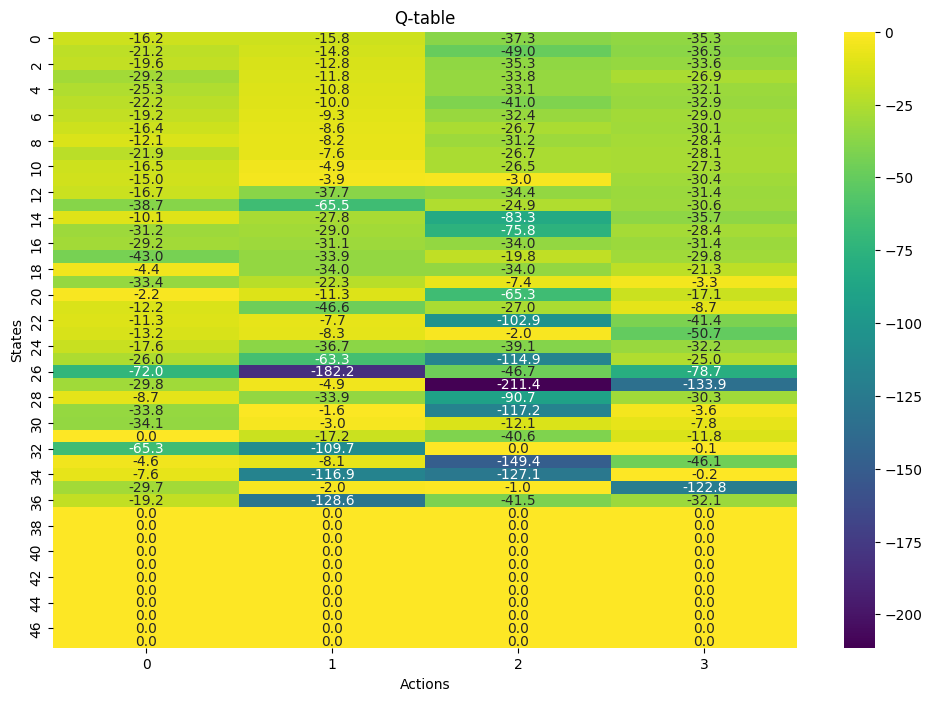

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_Q(Q):
  plt.figure(figsize=(12, 8))
  sns.heatmap(Q, annot=True, fmt=".1f", cmap="viridis")
  plt.xlabel("Actions")
  plt.ylabel("States")
  plt.title("Q-table")
  plt.show()

plot_Q(sarsa_Q)

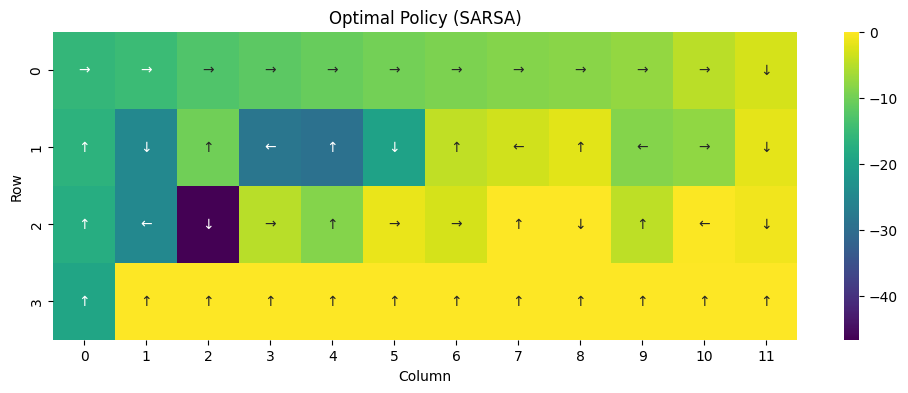

In [ ]:
def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Optimal Policy (SARSA)")
  plt.show()
plot_policy(sarsa_Q)

## Exercise 2.1: Q: Learning
Implement Q-learning method to solve the cliff problem

In [ ]:

import gymnasium as gym
import numpy as np
from tqdm import tqdm


def qlearning(print_rewards=False, is_slippery=False):
  # Create the environment
  if is_slippery:
    env = gym.make("CliffWalking-v1", render_mode="ansi", is_slippery=True)
  else:
    env = gym.make("CliffWalking-v1", render_mode="ansi")

  n_episodes = 10000      # number of episodes to run
  max_steps = 100     # safety cap

  # Q-learning parameters
  learning_rate = 0.1
  epsilon = 0.01
  discount_factor = 0.99
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states, n_actions))
  rewards = []
  def get_e_greedy_action(e):
      epsilon_loc = e
      def get_action(q_loc, env_loc, state_loc):
          if np.random.random() < epsilon_loc:
              return env_loc.action_space.sample()
          else:
              return np.argmax(q_loc[state])
      return get_action


  actin_selector = get_e_greedy_action(e=epsilon)

  for episode in range(n_episodes):
      done = False
      total_reward = 0
      state, info = env.reset()

      for step in range(max_steps):
        action = actin_selector(Q, env, state)
        next_state, reward, terminated, truncated, info = env.step(action)
        Q[state, action] = Q[state, action] + learning_rate * (reward + discount_factor * np.max(Q[next_state]) - Q[state, action])
        state = next_state
        total_reward += reward

        if terminated or truncated:
            break
      if print_rewards:
        print(f"Episode {episode+1}: total reward = {total_reward}")
      rewards.append(total_reward)
  return Q, rewards, n_actions
qlearning_Q, qlearning_rewards, n_actions = qlearning(True, False)

Streaming output truncated to the last 5000 lines.
Episode 5001: total reward = -13
Episode 5002: total reward = -13
Episode 5003: total reward = -13
Episode 5004: total reward = -13
Episode 5005: total reward = -13
Episode 5006: total reward = -13
Episode 5007: total reward = -20
Episode 5008: total reward = -13
Episode 5009: total reward = -13
Episode 5010: total reward = -13
Episode 5011: total reward = -13
Episode 5012: total reward = -13
Episode 5013: total reward = -13
Episode 5014: total reward = -13
Episode 5015: total reward = -13
Episode 5016: total reward = -13
Episode 5017: total reward = -13
Episode 5018: total reward = -13
Episode 5019: total reward = -13
Episode 5020: total reward = -13
Episode 5021: total reward = -13
Episode 5022: total reward = -13
Episode 5023: total reward = -13
Episode 5024: total reward = -15
Episode 5025: total reward = -13
Episode 5026: total reward = -13
Episode 5027: total reward = -13
Episode 5028: total reward = -13
Episode 5029: total rewar

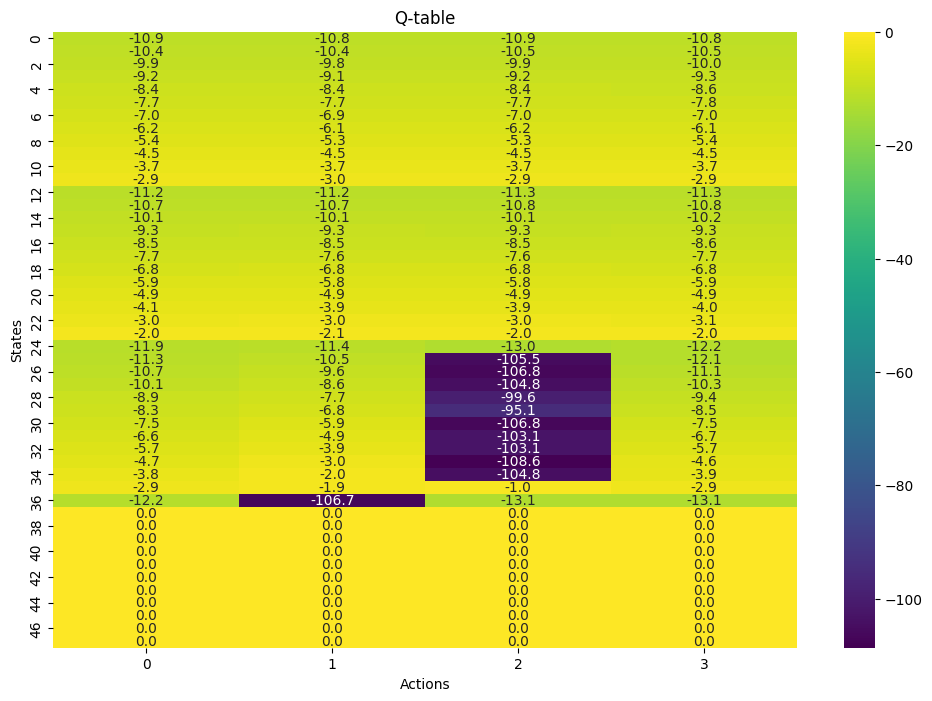

In [ ]:
plot_Q(qlearning_Q)

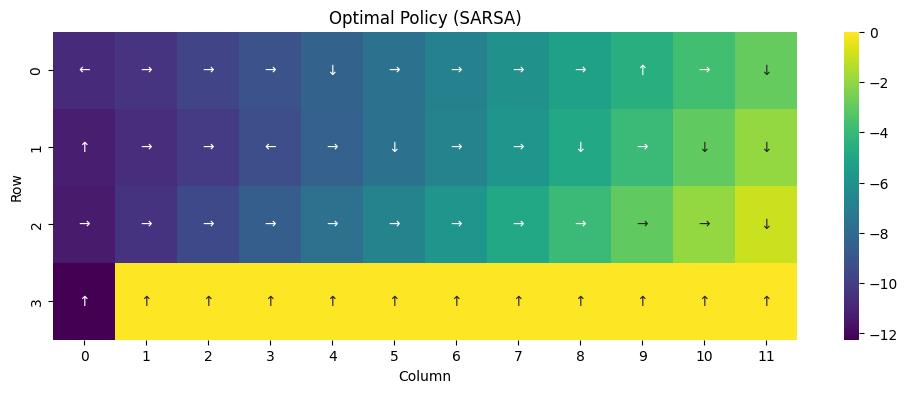

In [ ]:
plot_policy(qlearning_Q, "Q-Learning")

## Exercise 2.2: SARSA vs Q-learning
 1. Compare the results betwen SARSA and Q-Learning (plot a graph of the sum of rewards duing each episode for each algorithm).
 2. Include the is_slippery=True parameter. Compare again, which one is better?


In [ ]:
import plotly.express as px
import pandas as pd

def plot_linearly(input_dict: dict, trend_window: int):
  df = pd.DataFrame.from_dict(input_dict)
  if trend_window:
    for col in df.columns:
      df[col] = df[col].rolling(window=trend_window).mean()
  fig = px.line(df, x=df.index, y=df.columns.tolist(), title='Comparing total reward trends between QLearning and SARSA')
  fig.show()

qlearning_Q, qlearning_rewards, n_actions = qlearning(False)
sarsa_Q, sarsa_rewards, n_actions = sarsa(False)
qlearning_Q_is, qlearning_rewards_is, n_actions = qlearning(False, is_slippery=True)
sarsa_Q_is, sarsa_rewards_is, n_actions = sarsa(False, is_slippery=True)
plot_linearly({'qlearning': qlearning_rewards, 'sarsa': sarsa_rewards, 'qlearning_is': qlearning_rewards_is, 'sarsa_is': sarsa_rewards_is}, trend_window=5)


# Exercise 3 (graduate students): 8x8 grid problem
Solve the 8x8 grid problem from the previous lab. You can use SARSA or Q-learning. How many episodes does it need to learn the optimal policy?
